# sscan as 1D Flyer

<font color="red">NOTE</font>: This notebook is under construction!

## 1D step scans using sscan record

Use the [sscan record](https://epics.anl.gov/bcda/synApps/sscan/sscanRecord.html) as an [ophyd Flyer](http://nsls-ii.github.io/bluesky/async.html) for [bluesky](http://nsls-ii.github.io/bluesky) data acquisition.  Consider the case of [1D step scans using sscan record](https://epics.anl.gov/bcda/synApps/sscan/sscanRecord.html#HEADING_1-1).

In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join(".", "bluesky")))
from instrument.collection import *

I Fri-23:08:42 - ############################################################ startup
I Fri-23:08:42 - logging started
I Fri-23:08:42 - logging level = 10
I Fri-23:08:42 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/collection.py
I Fri-23:08:42 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/mpl/notebook.py


Activating auto-logging. Current session state plus future input saved.
Filename       : /home/mintadmin/Documents/projects/BCDA-APS/bluesky_training/.logs/ipython_console.log
Mode           : rotate
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


I Fri-23:08:42 - #### Bluesky Framework ####
I Fri-23:08:42 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/framework/check_python.py
I Fri-23:08:42 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/framework/check_bluesky.py
I Fri-23:08:43 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/framework/initialize.py
I Fri-23:08:43 - using databroker catalog 'training'
I Fri-23:08:43 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/framework/metadata.py
I Fri-23:08:43 - #### Devices ####
I Fri-23:08:43 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/devices/area_detector.py
I Fri-23:08:43 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/devices/calculation_records.py
I Fri-23:08:47 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/devices/ioc_stats.py
I Fri-23:08:

In [2]:
from apstools.synApps import SaveData
from apstools.synApps import SscanDevice

ioc = "gp:"

save_data = SaveData(f"{ioc}saveData_", name="save_data")

In [3]:
from apstools.synApps import SscanRecord
scan = SscanRecord(f"{ioc}scan1", name="scan")

scan.wait_for_connection()  # sscan records have _many_ channels and fields
scan.select_channels()

# configure the sscan record for data collection:
scan.reset()  # clear out any previous configuration

scan.number_points.put(6)
scan.positioners.p1.setpoint_pv.put(m1.user_setpoint.pvname)
scan.positioners.p1.readback_pv.put(m1.user_readback.pvname)
scan.positioners.p1.start.put(-1)
scan.positioners.p1.end.put(0)
scan.positioner_delay.put(0.0)
scan.detector_delay.put(0.1)
scan.detectors.d01.input_pv.put(scaler1.channels.chan03.s.pvname)
scan.detectors.d02.input_pv.put(scaler1.channels.chan02.s.pvname)
scan.triggers.t1.trigger_pv.put(scaler1.count.pvname)

# finally, reconfigure
scan.select_channels()

In [4]:
# configure saveData for data collection into MDA files:
save_data.file_system.put("/tmp")
save_data.subdirectory.put("saveData")
save_data.base_name.put("sscan1_")
save_data.next_scan_number.put(1)
save_data.comment1.put("testing")
save_data.comment2.put("configured and run from ophyd")

In [5]:
# TODO: make a plan for bluesky

# probably does not need to be a Flyer
# still, try to make it fit

from ophyd.flyers import FlyerInterface

class SscanFlyer_1D_StepSimple(FlyerInterface):

    def kickoff(self):
        # http://nsls-ii.github.io/ophyd/generated/ophyd.flyers.FlyerInterface.kickoff.html
        pass   # -> StatusBase

    def complete(self):
        # http://nsls-ii.github.io/ophyd/generated/ophyd.flyers.FlyerInterface.complete.html
        pass   # -> StatusBase

    def describe_collect(self):
        # http://nsls-ii.github.io/ophyd/generated/ophyd.flyers.FlyerInterface.describe_collect.html
        pass   # -> Dict[str, Dict]

    def collect(self):
        # http://nsls-ii.github.io/ophyd/generated/ophyd.flyers.FlyerInterface.collect.html
        pass   # -> Generator[Dict, None, None]

    def collect_tables(self):
        pass   # -> Iterable[Any]

## MockFlyer with motor and pseudo-detector

ophyd's *MockFlyer* example : https://github.com/NSLS-II/ophyd/blob/master/ophyd/sim.py#L546

In [6]:
import asyncio
from collections import deque
from collections import OrderedDict
from ophyd import DeviceStatus
import time

class MockFlyer:
    """
    Class for mocking a flyscan API implemented with stepper motors.
    """

    def __init__(self, name, detector, motor, start, stop, num, loop=None):
        self.name = name
        self.parent = None
        self._mot = motor
        self._detector = detector
        self._steps = np.linspace(start, stop, num)
        self._data = deque()
        self._completion_status = None
        if loop is None:
            loop = asyncio.get_event_loop()
        self.loop = loop

    def __setstate__(self, val):
        name, detector, motor, steps = val
        self.name = name
        self.parent = None
        self._mot = motor
        self._detector = detector
        self._steps = steps
        self._completion_status = None
        self.loop = asyncio.get_event_loop()

    def __getstate__(self):
        return (self.name, self._detector, self._mot, self._steps)

    def read_configuration(self):
        return OrderedDict()

    def describe_configuration(self):
        return OrderedDict()

    def describe_collect(self):
        dd = dict()
        dd.update(self._mot.describe())
        dd.update(self._detector.describe())
        return {'stream_name': dd}

    def complete(self):
        if self._completion_status is None:
            raise RuntimeError("No collection in progress")
        return self._completion_status

    def kickoff(self):
        if self._completion_status is not None:
            raise RuntimeError("Already kicked off.")
        self._data = deque()

        self._future = self.loop.run_in_executor(None, self._scan)
        st = DeviceStatus(device=self)
        self._completion_status = st
        self._future.add_done_callback(lambda x: st._finished())
        return st

    def collect(self):
        if self._completion_status is None or not self._completion_status.done:
            raise RuntimeError("No reading until done!")
        self._completion_status = None

        yield from self._data

    def _scan(self):
        "This will be run on a separate thread, started in self.kickoff()"
        time.sleep(.1)
        for p in self._steps:
            stat = self._mot.set(p)
            while True:
                if stat.done:
                    break
                time.sleep(0.01)
            stat = self._detector.trigger()
            while True:
                if stat.done:
                    break
                time.sleep(0.01)

            event = dict()
            event['time'] = time.time()
            event['data'] = dict()
            event['timestamps'] = dict()
            for r in [self._mot, self._detector]:
                d = r.read()
                for k, v in d.items():
                    event['data'][k] = v['value']
                    event['timestamps'][k] = v['timestamp']
            self._data.append(event)

    def stop(self, *, success=False):
        pass


In [7]:
mflyer = MockFlyer('mflyer', noisy, m1, 1, 5, 20)



Transient Scan ID: 353     Time: 2021-08-20 23:08:50
Persistent Unique Scan ID: '3934b930-5a91-4ae2-8ce2-380413e1b7c9'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         m1 |      noisy |
+-----------+------------+------------+------------+
|         1 | 23:08:57.4 |   -1.10000 |   45.11507 |
|         2 | 23:08:58.0 |   -0.88000 |   65.13253 |
|         3 | 23:08:58.6 |   -0.66000 |  102.77275 |
|         4 | 23:08:59.1 |   -0.44000 |  177.91237 |
|         5 | 23:08:59.6 |   -0.22000 |  403.98239 |
|         6 | 23:09:00.1 |    0.00000 | 1540.96112 |
|         7 | 23:09:00.6 |    0.22000 | 84035.73578 |
|         8 | 23:09:01.1 |    0.44000 | 1725.22459 |
|         9 | 23:09:01.6 |    0.66000 |  417.99179 |
|        10 | 23:09:02.1 |    0.88000 |  184.99646 |
|        11 | 23:09:02.6 |    1.10000 |  103.51405 |
+-----------+------------+------------+------------+
generator scan ['3934b930'] (scan num:

('3934b930-5a91-4ae2-8ce2-380413e1b7c9',)

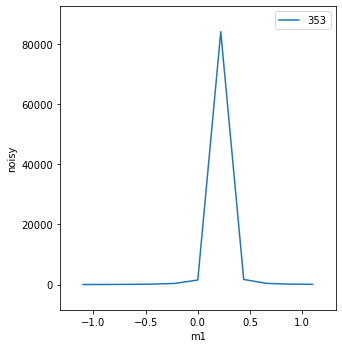

In [8]:
RE(bp.scan([noisy], m1, -1.1, 1.1, 11))

In [9]:
run = cat[-1]
run.primary.read()

<xarray.Dataset>
Dimensions:           (time: 11)
Coordinates:
  * time              (time) float64 1.63e+09 1.63e+09 ... 1.63e+09 1.63e+09
Data variables:
    m1                (time) float64 -1.1 -0.88 -0.66 -0.44 ... 0.66 0.88 1.1
    m1_user_setpoint  (time) float64 -1.1 -0.88 -0.66 -0.44 ... 0.66 0.88 1.1
    noisy             (time) float64 45.12 65.13 102.8 ... 418.0 185.0 103.5